In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:


# 1) Read the CSV into a DataFrame
df_ts = pd.read_csv('../data/cleaned_data.csv')

# 2) Strip whitespace from column names to avoid mismatches
df_ts.columns = df_ts.columns.str.strip()

# 3) Inspect the raw Date values before conversion
print("Raw Date values (first 5):")
print(df_ts['Date'].head())

# 4) Convert the 'Date' column to datetime using day/month/year format

df_ts['Date'] = pd.to_datetime(
    df_ts['Date'],
    format='%d/%m/%y',
    dayfirst=True,
    errors='coerce'
)

# 5) Check after conversion
print("Converted Date values (first 5):")
print(df_ts['Date'].head())

# 6) Drop rows where 'Date' conversion failed (optional)
df_ts = df_ts.dropna(subset=['Date'])

# 7) Set Date as the index for time-series operations
df_ts = df_ts.set_index('Date')

# Check of actual date range
display(df_ts.index.min(), df_ts.index.max())

Raw Date values (first 5):
0    24/11/23
1     27/2/23
2     13/1/23
3     21/5/23
4      6/5/23
Name: Date, dtype: object
Converted Date values (first 5):
0   2023-11-24
1   2023-02-27
2   2023-01-13
3   2023-05-21
4   2023-05-06
Name: Date, dtype: datetime64[ns]


Timestamp('2023-01-01 00:00:00')

Timestamp('2024-01-01 00:00:00')

In [3]:
# Resample to month end frequency, summing TotalAmount
gmonthly = (
    df_ts['Total Amount']
    .resample('M')       # 'M' = month end
    .sum()
    .to_frame(name='MonthlySales')
)

display(gmonthly.head())

C:\Users\spide\AppData\Local\Temp\ipykernel_28724\2454603682.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')       # 'M' = month end


,MonthlySales
Date,
2023-01-31,35450.0
2023-02-28,44060.0
2023-03-31,28990.0
2023-04-30,33870.0
2023-05-31,53150.0


<Figure size 640x480 with 0 Axes>

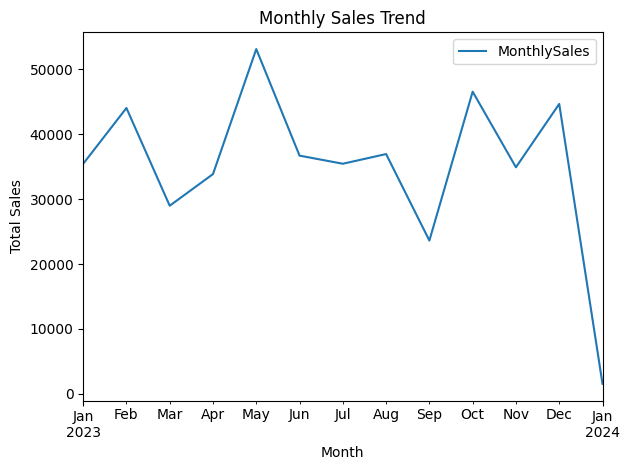

In [4]:
#Monthly sales trend plot
plt.figure()
gmonthly.plot(title='Monthly Sales Trend')
plt.ylabel('Total Sales')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

In [5]:
# Create Quarter period column on the original DataFrame
df_ts['Quarter'] = df_ts.index.to_period('Q')

# Aggregate by Quarter period
gquarterly = (
    df_ts.groupby('Quarter')['Total Amount']
    .sum()
    .to_frame(name='QuarterlySales')
)

# Exclude 2024Q1 if data is limited
if pd.Period('2024Q1', freq='Q') in gquarterly.index:
    gquarterly_filtered = gquarterly.drop(pd.Period('2024Q1', freq='Q'))
else:
    gquarterly_filtered = gquarterly

display(gquarterly_filtered)
display(gquarterly)

,QuarterlySales
Quarter,
2023Q1,108500.0
2023Q2,123735.0
2023Q3,96045.0
2023Q4,126190.0


,QuarterlySales
Quarter,
2023Q1,108500.0
2023Q2,123735.0
2023Q3,96045.0
2023Q4,126190.0
2024Q1,1530.0


<Figure size 640x480 with 0 Axes>

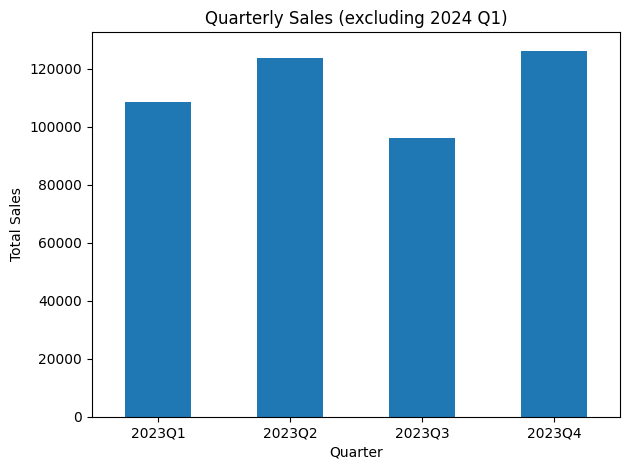

<Figure size 640x480 with 0 Axes>

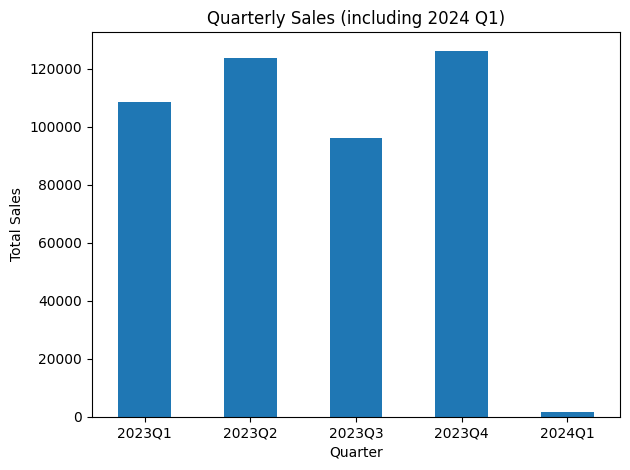

In [6]:
#Quartertly sales (excluding 2024 Q1)
plt.figure()
# Plot filtered quarterly sales
gquarterly_filtered.plot(kind='bar', legend=False)
plt.title('Quarterly Sales (excluding 2024 Q1)')
plt.ylabel('Total Sales')
plt.xlabel('Quarter')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#Quartertly sales (including 2024 Q1)
plt.figure()
# Plot filtered quarterly sales
gquarterly.plot(kind='bar', legend=False)
plt.title('Quarterly Sales (including 2024 Q1)')
plt.ylabel('Total Sales')
plt.xlabel('Quarter')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Using data through 2024


,MonthlySales
Date,
2023-01-31,35450.0
2023-02-28,44060.0
2023-03-31,28990.0
2023-04-30,33870.0
2023-05-31,53150.0
2023-06-30,36715.0
2023-07-31,35465.0
2023-08-31,36960.0
2023-09-30,23620.0


,ForecastSales
2024-02-29,27488.870890
2024-03-31,26383.308695
2024-04-30,25313.409797
2024-05-31,24207.847602
2024-06-30,23137.948704
2024-07-31,22032.386509


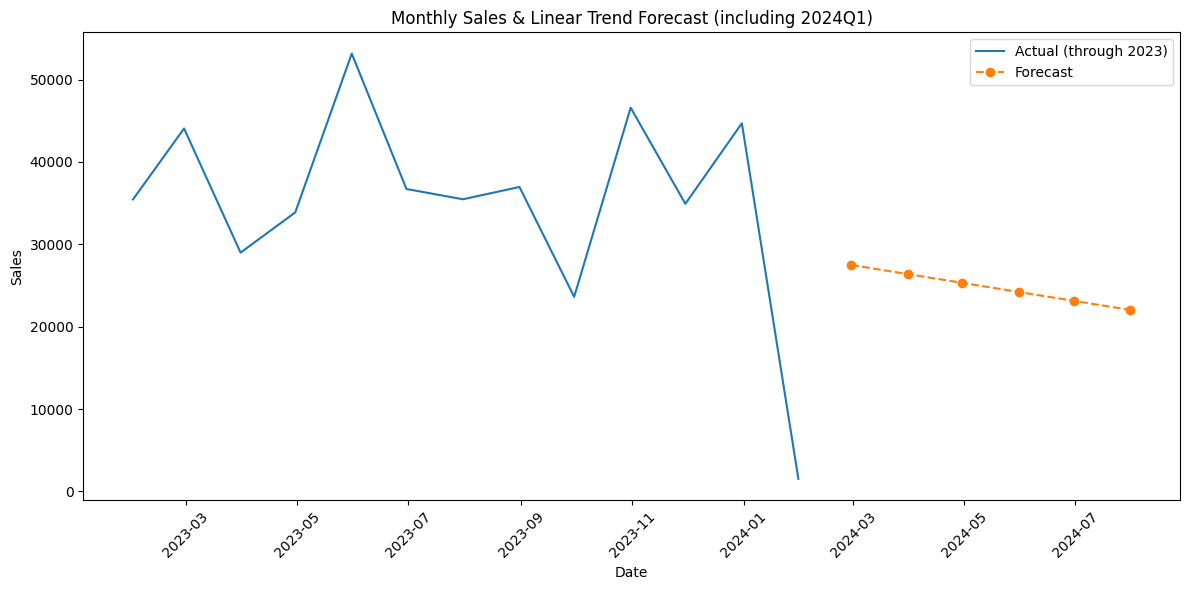

In [7]:
#Monthly Sales & Linear Trend Forecast (including 2024Q1)


# 1) Filter monthly data to exclude 2024-Q1
#    Keep data up through December 2023
end_date = '2024'
gmonthly = gmonthly.loc[:end_date]

# Prepare the data for regression
# Use monthly index converted to integer ordinal for fitting
dates = gmonthly.index.map(lambda x: x.toordinal()).values.reshape(-1, 1)
sales = gmonthly['MonthlySales'].values

# Fit a linear regression model
global_model = LinearRegression()
global_model.fit(dates, sales)

# Predict the next 6 months from the last date in filtered data
ahead = 6
last_date = gmonthly.index[-1]
future_dates = [last_date + pd.DateOffset(months=i) for i in range(1, ahead+1)]
future_ordinals = np.array([d.toordinal() for d in future_dates]).reshape(-1, 1)
predictions = global_model.predict(future_ordinals)

# Build a DataFrame of forecasts
forecast = pd.DataFrame({
    'ForecastSales': predictions
}, index=future_dates)

# Display filtered actuals and forecasts
print("Using data through", end_date)
display(gmonthly)
display(forecast)

# Plot both series
plt.figure(figsize=(12, 6))
plt.plot(gmonthly.index, gmonthly['MonthlySales'], label='Actual (through 2023)')
plt.plot(forecast.index, forecast['ForecastSales'], '--o', label='Forecast')
plt.title('Monthly Sales & Linear Trend Forecast (including 2024Q1)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Using data through 2023-12-31


,MonthlySales
Date,
2023-01-31,35450.0
2023-02-28,44060.0
2023-03-31,28990.0
2023-04-30,33870.0
2023-05-31,53150.0
2023-06-30,36715.0
2023-07-31,35465.0
2023-08-31,36960.0
2023-09-30,23620.0


,ForecastSales
2024-01-31,38822.025595
2024-02-29,38960.340750
2024-03-31,39108.194882
2024-04-30,39251.279526
2024-05-31,39399.133658
2024-06-30,39542.218302


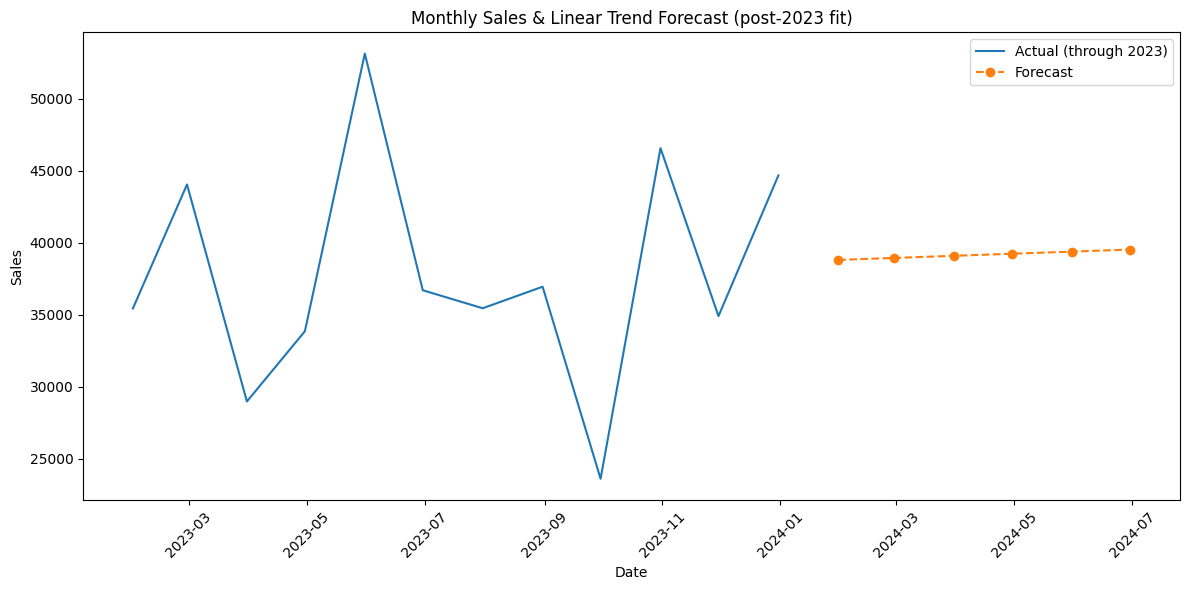

In [8]:

# 1) Filter monthly data to exclude 2024-Q1
#    Keep data up through December 2023
end_date = '2023-12-31'
gmonthly_filtered = gmonthly.loc[:end_date]

# Prepare the data for regression
# Use monthly index converted to integer ordinal for fitting
dates = gmonthly_filtered.index.map(lambda x: x.toordinal()).values.reshape(-1, 1)
sales = gmonthly_filtered['MonthlySales'].values

# Fit a linear regression model
global_model = LinearRegression()
global_model.fit(dates, sales)

# Predict the next 6 months from the last date in filtered data
ahead = 6
last_date = gmonthly_filtered.index[-1]
future_dates = [last_date + pd.DateOffset(months=i) for i in range(1, ahead+1)]
future_ordinals = np.array([d.toordinal() for d in future_dates]).reshape(-1, 1)
predictions = global_model.predict(future_ordinals)

# Build a DataFrame of forecasts
forecast = pd.DataFrame({
    'ForecastSales': predictions
}, index=future_dates)

# Display filtered actuals and forecasts
print("Using data through", end_date)
display(gmonthly_filtered)
display(forecast)

# Plot both series
plt.figure(figsize=(12, 6))
plt.plot(gmonthly_filtered.index, gmonthly_filtered['MonthlySales'], label='Actual (through 2023)')
plt.plot(forecast.index, forecast['ForecastSales'], '--o', label='Forecast')
plt.title('Monthly Sales & Linear Trend Forecast (post-2023 fit)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\spide\AppData\Local\Temp\ipykernel_28724\526682757.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_ts.groupby([pd.Grouper(freq='M'), 'Product Category'])['Total Amount']


Product Category,Beauty,Clothing,Electronics
Date,,,
2023-01-31,12430.0,13125.0,9895.0
2023-02-28,14035.0,14560.0,15465.0
2023-03-31,10545.0,15065.0,3380.0
2023-04-30,11905.0,13940.0,8025.0
2023-05-31,12450.0,17455.0,23245.0
2023-06-30,10995.0,10170.0,15550.0
2023-07-31,16090.0,8250.0,11125.0
2023-08-31,9790.0,12455.0,14715.0
2023-09-30,6320.0,9975.0,7325.0


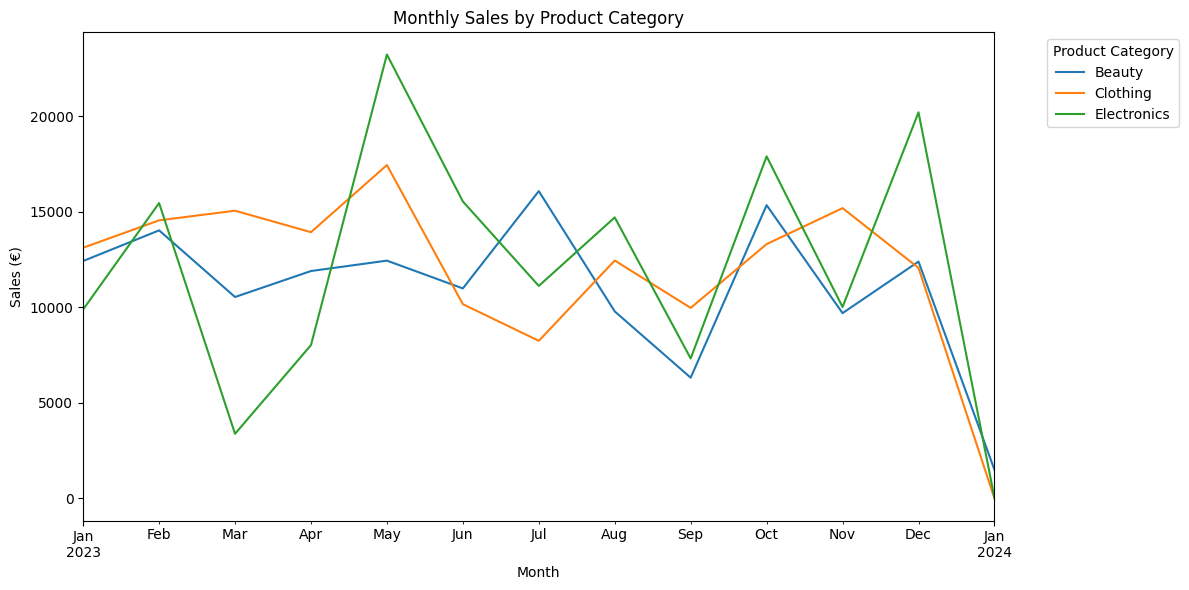

C:\Users\spide\AppData\Local\Temp\ipykernel_28724\526682757.py:21: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_ts.groupby([pd.Grouper(freq='Q'), 'Product Category'])['Total Amount']


Product Category,Beauty,Clothing,Electronics
Date,,,
2023-03-31,37010.0,42750.0,28740.0
2023-06-30,35350.0,41565.0,46820.0
2023-09-30,32200.0,30680.0,33165.0
2023-12-31,37455.0,40585.0,48150.0
2024-03-31,1500.0,0.0,30.0


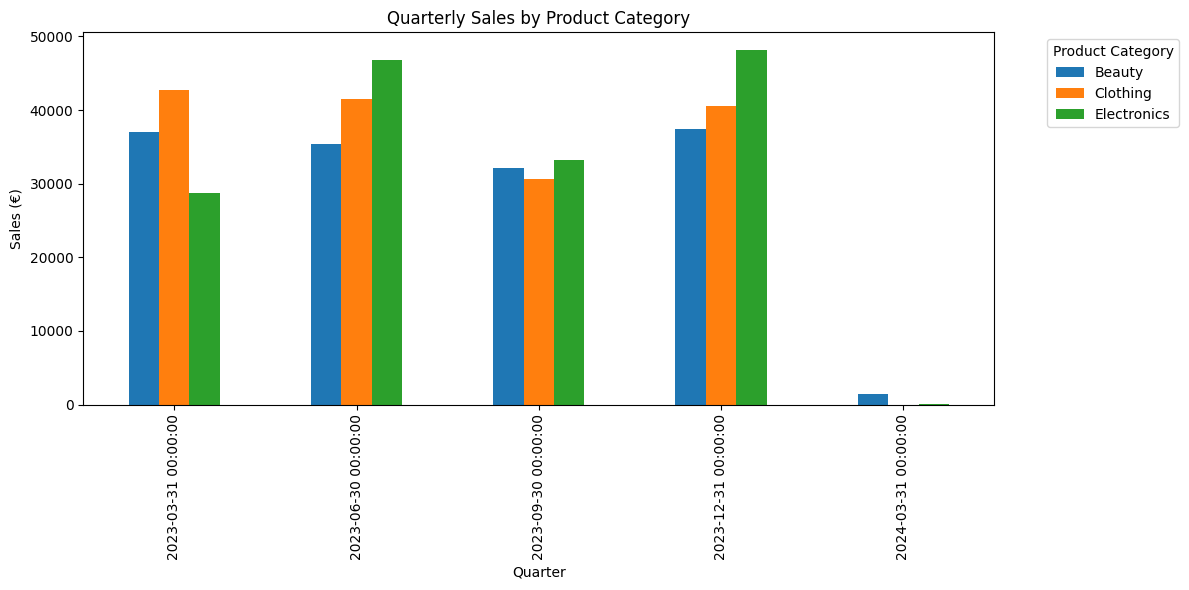

In [9]:
# Aggregate monthly sales by product category
df_monthly_cat = (
    df_ts.groupby([pd.Grouper(freq='M'), 'Product Category'])['Total Amount']
    .sum()
    .unstack(fill_value=0)
)

display(df_monthly_cat)

# Plot monthly sales by category
df_monthly_cat.plot(figsize=(12, 6))
plt.title('Monthly Sales by Product Category')
plt.xlabel('Month')
plt.ylabel('Sales (€)')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Aggregate quarterly sales by product category
df_quarterly_cat = (
    df_ts.groupby([pd.Grouper(freq='Q'), 'Product Category'])['Total Amount']
    .sum()
    .unstack(fill_value=0)
)

display(df_quarterly_cat)

# Plot quarterly sales by category
df_quarterly_cat.plot(kind='bar', figsize=(12, 6))
plt.title('Quarterly Sales by Product Category')
plt.xlabel('Quarter')
plt.ylabel('Sales (€)')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

,Beauty,Clothing,Electronics
2024-02-29,7958.966391,7926.857929,11603.046569
2024-03-31,7510.122738,7338.117418,11535.068539
2024-04-30,7075.757913,6768.368536,11469.283348


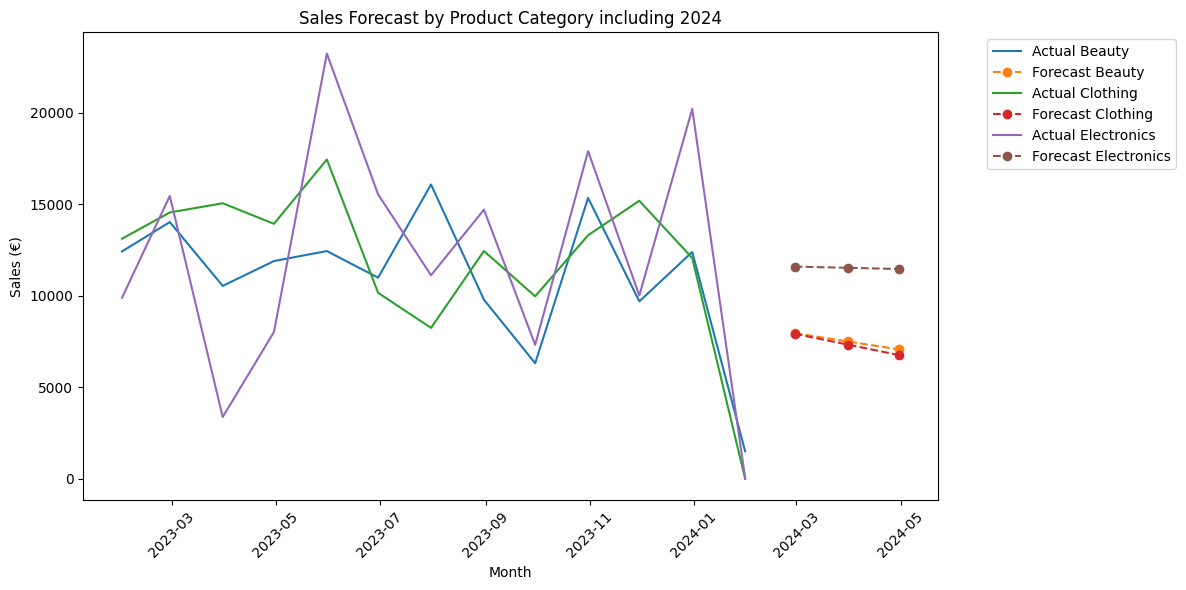

In [10]:


# 1) Prepare the monthly sales pivot (from Section 9.4)
#    df_monthly_cat: index=Month, columns=Product Category
monthly = df_monthly_cat.copy()

# 2) Container for forecasts
forecasts = {}

# 3) Loop through each category
for category in monthly.columns:
    # Prepare data: dates as ordinals, values as sales
    dates = monthly.index.to_series().map(lambda x: x.toordinal()).values.reshape(-1,1)
    sales = monthly[category].values

    # Fit linear regression
    glm = LinearRegression()
    glm.fit(dates, sales)

    # Forecast next 3 months from last date
    last_date = monthly.index[-1]
    future_dates = [last_date + pd.DateOffset(months=i) for i in range(1,4)]
    future_ordinals = np.array([d.toordinal() for d in future_dates]).reshape(-1,1)
    pred = glm.predict(future_ordinals)

    # Store in DataFrame
    forecasts[category] = pd.Series(pred, index=future_dates)

# 4) Combine forecast series into a DataFrame
df_forecast = pd.DataFrame(forecasts)

display(df_forecast)

# 5) Plot forecasts alongside historical
plt.figure(figsize=(12,6))
for category in monthly.columns:
    plt.plot(monthly.index, monthly[category], label=f"Actual {category}")
    plt.plot(df_forecast.index, df_forecast[category], '--o', label=f"Forecast {category}")
plt.title('Sales Forecast by Product Category including 2024')
plt.xlabel('Month')
plt.ylabel('Sales (€)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

,Beauty,Clothing,Electronics
2024-01-31,11003.401894,11712.154822,16106.468879
2024-02-29,10882.325653,11529.655817,16548.359281
2024-03-31,10752.899326,11334.570674,17020.724882


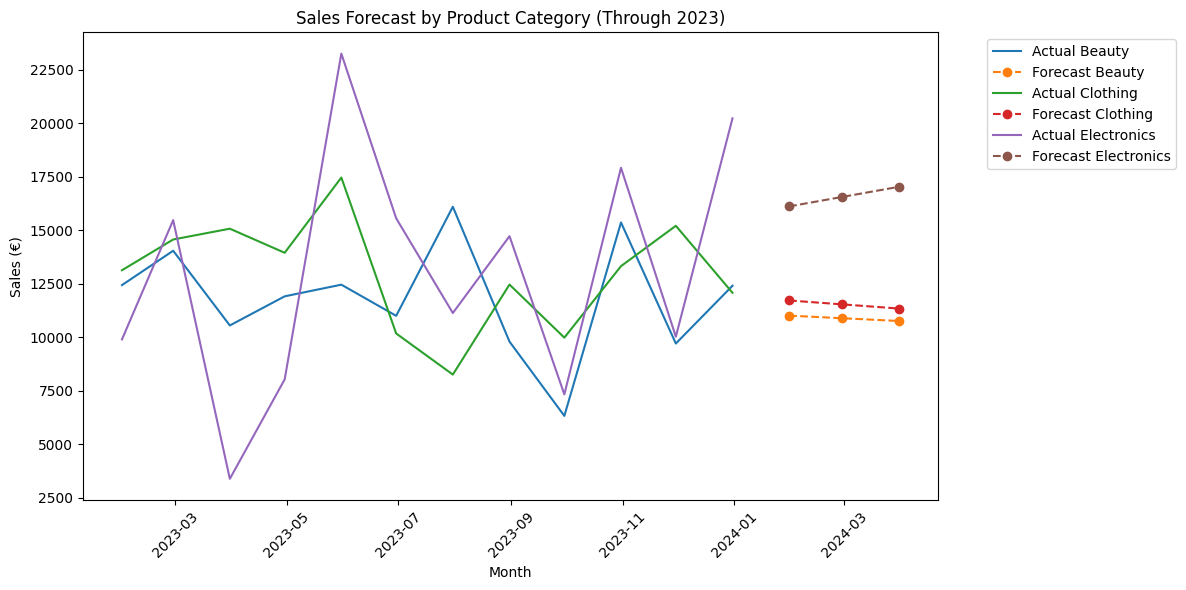

In [11]:
#Excluding 2024
# 1) Filter monthly data to end of 2023
monthly_excl2024 = monthly.loc[:'2023-12-31']

# 2) Container for filtered forecasts
forecasts_excl = {}

# 3) Loop per category
for category in monthly_excl2024.columns:
    # Prepare features
    dates_f = monthly_excl2024.index.to_series().map(lambda x: x.toordinal()).values.reshape(-1,1)
    sales_f = monthly_excl2024[category].values

    # Fit model
    model_f = LinearRegression()
    model_f.fit(dates_f, sales_f)

    # Forecast next 3 months beyond Dec 2023
    ahead = 3
    last_date_f = monthly_excl2024.index[-1]
    future_dates_f = [last_date_f + pd.DateOffset(months=i) for i in range(1, ahead+1)]
    future_ordinals_f = np.array([d.toordinal() for d in future_dates_f]).reshape(-1,1)
    preds_f = model_f.predict(future_ordinals_f)

    # Store forecasts
    forecasts_excl[category] = pd.Series(preds_f, index=future_dates_f)

# 4) Build DataFrame and display
df_forecast_excl = pd.DataFrame(forecasts_excl)
display(df_forecast_excl)

# 5) Plot actual vs. forecast
plt.figure(figsize=(12,6))
for category in monthly_excl2024.columns:
    plt.plot(monthly_excl2024.index, monthly_excl2024[category], label=f"Actual {category}")
    plt.plot(df_forecast_excl.index, df_forecast_excl[category], '--o', label=f"Forecast {category}")
plt.title('Sales Forecast by Product Category (Through 2023)')
plt.xlabel('Month')
plt.ylabel('Sales (€)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()